# Sequential Sentence Classification in Medical Abstracts

This project is made in order to try ro replicate the work that was done by Franck Dernoncourt, Ji Young Lee in 2017: [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). The model that will be replicated is described in paper in details, however I will do some other experiments with the data prepared by the authors of original works. I will also implement some ideas that were proposed in the course [Zero to Mastery Deep Learning with TensorFlow](https://github.com/mrdbourke/tensorflow-deep-learning) in the section: [09: Milestone project: SkimLit](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb).

The model is supposed to take an abstract text and predict the section label that each sentence should have.

In [1]:
import datetime
print(f"Notebook last run: {datetime.datetime.now()}")

Notebook last run: 2024-03-26 09:06:45.238903


## Getting the data

The authors of the original paper made the PubMed 200k RCT dataset publically available, so I will copy in to my local directory

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


I will start working using `PubMed_20k_RCT_numbers_replaced_with_at_sign` dataset, since it is a smaller subset and it does not contain numbers, that might make modeling harder.

In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
import os
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

## Data preprocessing

In [5]:
# function to read the lines in the document
def get_lines(file):
  with open(file, "r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Now I will write the function that tranforms the lines into the list of dictionaries:
- line_numer: the position of the line in the abstract
- target: the role of the line
- text: the text of the line
- total_lines - the total number of lines

In [7]:
def preprocess_text(file):
  input_lines = get_lines(file)
  abstract = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract
    elif line.isspace(): # is the line is new line
      abstract_line_split = abstract_lines.splitlines() # split the abstract

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split)
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples


Now I will preprocess all subsets

In [8]:
train_samples = preprocess_text(data_dir + "/train.txt")
val_samples = preprocess_text(data_dir + "/dev.txt")
test_samples = preprocess_text(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)


(180040, 30212, 30135)

In [9]:
train_samples[:7]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

I will also use Pandas to do some visualization for better unsderstanding the data

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [11]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

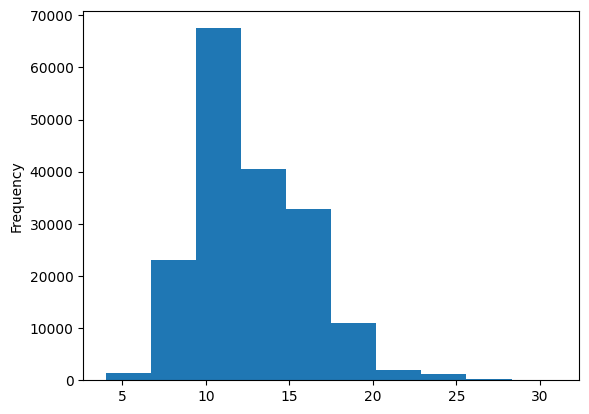

In [12]:
train_df.total_lines.plot.hist()

For modeling I will convert `text` columns to a list of strings

In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
print(len(train_sentences), len(val_sentences), len(test_sentences))
train_sentences[:10]

180040 30212 30135


['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Since the labels are given as text, I will do one-hot encoding as for further modeling.

In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
# encoding labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(f"There are {num_classes} classes: {class_names}")

There are 5 classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


Data is ready for modeling.

## Model experiments

### Model 0. Baseline

As a baseline model I will have a TF-IDF Multinomial Naive Bayes.

I will use `TfidfVectorizer` and `MultinomialNB` algorithm.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("TD-IDF", TfidfVectorizer()),
    ("CLF", MultinomialNB())
])

# fit the pipeline to data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('TD-IDF', TfidfVectorizer()), ('CLF', MultinomialNB())])

In [18]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

For comparing the models I will write the function that calculate the metrics (Accuracy, Precision, Recall, F1)

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": accuracy,
                  "precision": precision,
                  "recall": recall,
                  "f1": f1}
  return model_results

In [20]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [21]:
model_0_metrics = calculate_metrics(val_labels_encoded, model_0_preds)
model_0_metrics

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

I will create a dataframe for containing the models' metrics

In [22]:
models_metrics = pd.DataFrame({"Baseline-MNB": model_0_metrics})
models_metrics = models_metrics.transpose()
models_metrics

,accuracy,f1,precision,recall
Baseline-MNB,0.721832,0.698925,0.718647,0.721832


## Preparing the data for deep sequence models

To use data for other models I will create vectorization and embedding layers.

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

The length of the sentence may vary significantly. To make the training faster, I will leave the data that contain length for 95% percentile.

In [24]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [25]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

The length 55 will be set.

**Creating text vectorizer**
The size of vocabulary will be set for 68k, since the it is stated to be 68000 in the PubMed 20k (ref. - original paper)

In [26]:
max_tokens = 68000

In [27]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [28]:
# adapting the vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [29]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
seventeen healthy subjects participated in this randomized , double-blinded , placebo-controlled crossover study .

Length of text: 14

Vectorized text:
[[4223  247  104  820    5   23   29 1675  329  484   17    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [30]:
# The number of words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)

64841

**Creating text embedding**

In [31]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero=True,
                               name="token_embedding")

In [32]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
seventeen healthy subjects participated in this randomized , double-blinded , placebo-controlled crossover study .

Sentence after vectorization (before embedding):
[[4223  247  104  820    5   23   29 1675  329  484   17    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.02313204  0.03002253  0.02777538 ... -0.0477841  -0.00841685
   -0.03203262]
  [ 0.04552615  0.02770488  0.01892177 ... -0.04025569  0.04059163
    0.02309712]
  [ 0.04488734 -0.00232993 -0.01852966 ...  0.00815328  0.02005248
    0.01386524]
  ...
  [-0.00249397 -0.04874292 -0.01406374 ...  0.04704517  0.02686417
    0.04456842]
  [-0.00249397 -0.04874292 -0.01406374 ...  0.04704517  0.02686417
    0.04456842]
  [-0.00249397 -0.04874292 -0.01406374 ...  0.04704517  0.02686417
    

I will also create a fast-loading dataset using pipelines

In [33]:
# Turning data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [34]:
# Taking the TensorSliceDataset's and turning them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Convolution with Embedding
Creating a convolutional model with vectorization and embedding using Keras Functional API



In [35]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [37]:
# fitting the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 73s 128ms/step - loss: 0.9286 - accuracy: 0.6350 - val_loss: 0.6885 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 70s 125ms/step - loss: 0.6600 - accuracy: 0.7542 - val_loss: 0.6367 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 66s 118ms/step - loss: 0.6195 - accuracy: 0.7731 - val_loss: 0.5983 - val_accuracy: 0.7839


In [38]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.5995 - accuracy: 0.7868


[0.5994773507118225, 0.786806583404541]

In [39]:
# make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 6s 7ms/step


array([[4.5332670e-01, 1.5546097e-01, 6.0347039e-02, 3.0864653e-01,
        2.2218734e-02],
       [4.3444154e-01, 2.6708496e-01, 1.5661167e-02, 2.7555922e-01,
        7.2531495e-03],
       [1.5078944e-01, 1.1176747e-02, 2.3987847e-03, 8.3557707e-01,
        5.7939309e-05],
       ...,
       [6.1579508e-06, 4.9329875e-04, 5.9122476e-04, 3.5321050e-06,
        9.9890578e-01],
       [5.7896208e-02, 4.2442951e-01, 1.2387063e-01, 8.8698730e-02,
        3.0510494e-01],
       [1.4395122e-01, 6.9407970e-01, 4.0586311e-02, 5.0558470e-02,
        7.0824251e-02]], dtype=float32)

In [40]:
# Converting pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [41]:
model_1_metrics = calculate_metrics(val_labels_encoded,
                                    model_1_preds)
model_1_metrics

{'accuracy': 0.7868065669270489,
 'precision': 0.783824860492257,
 'recall': 0.7868065669270489,
 'f1': 0.7843238840695135}

In [42]:
models_metrics = models_metrics.append(pd.DataFrame({"Model 1 - Conv. with Embed.": model_1_metrics}).transpose())

<ipython-input-42-4aebd292d55b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(pd.DataFrame({"Model 1 - Conv. with Embed.": model_1_metrics}).transpose())


In [43]:
models_metrics

,accuracy,f1,precision,recall
Baseline-MNB,0.721832,0.698925,0.718647,0.721832
Model 1 - Conv. with Embed.,0.786807,0.784324,0.783825,0.786807


### Model 2: Pretrained Embeddings + character embeddings

In this model I will use a combination of token embeddings and character embeddings.

As a pretrained embedding layer I will use the Universal Sentence Encoder from TensorFlow Hub. (In the original paper authors used GloVe embedding)

#### Importing Embedding from Hub

In [44]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [45]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
st seems to have a clinically relevant beneficial short-term effect on pfl compared to cpm .

Sentence after embedding:
[ 0.02485534 -0.04253343 -0.00970181 -0.05335644  0.02000345  0.01337808
 -0.043788   -0.067326    0.04628644  0.0402813   0.01162574  0.05653257
 -0.09100512  0.06706832  0.02038238 -0.02339256 -0.10300166 -0.02398228
 -0.07840472 -0.0287702  -0.05784976  0.0325647  -0.02189853 -0.00759342
  0.0379184  -0.05287318 -0.01410881  0.0467213  -0.00301863  0.0775382 ] (truncated output)...

Length of sentence embedding:
512


#### Creating character tokenizer

First I will split the sentences into characters, create character-level dataset and then I will create an embedding layer.

In [46]:
# function to split sentences
def split_into_chars(text):
  return " ".join(list(text))

split_into_chars(random_training_sentence)

's t   s e e m s   t o   h a v e   a   c l i n i c a l l y   r e l e v a n t   b e n e f i c i a l   s h o r t - t e r m   e f f e c t   o n   p f l   c o m p a r e d   t o   c p m   .'

In [47]:
# sequence-level data -> character-level data
train_chars = [split_into_chars(sentence) for sentence in train_sentences]
val_chars = [split_into_chars(sentence) for sentence in val_sentences]
test_chars = [split_into_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [48]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

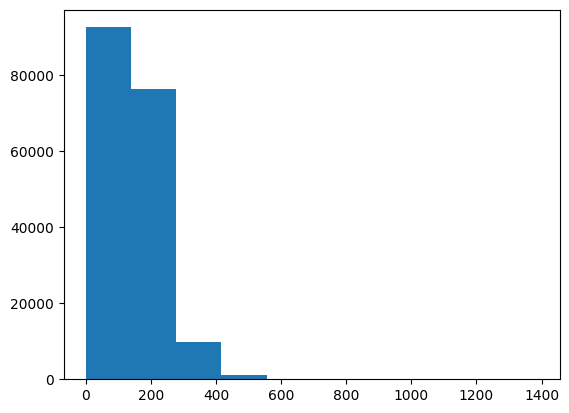

In [49]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10);

I will use the length that falls in 95% percentile of the data

In [50]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

To set maximun number of tokens I will get all keyboard characters

In [51]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [52]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # aplhabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [53]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [54]:
# create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [55]:
# Test out character embedding layer
random_train_chars = random.choice(train_chars)
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
@   %   o f   t h e   p a r t i c i p a n t s   r e p o r t e d   i m p r o v e m e n t   a f t e r   t r e a t m e n t   ,   a n d   @   %   m e n t i o n e d   a n   i n c r e a s e   i n   d i z z i n e s s   o n   f o l l o w - u p   .

Embedded chars (after vectorization and embedding):
[[[ 0.03338471 -0.03416278  0.03319656 ...  0.01392938 -0.01054363
    0.03946886]
  [ 0.01642439 -0.0121784  -0.01943597 ... -0.04345489 -0.02898933
   -0.01411902]
  [-0.01240921  0.02226526 -0.02286463 ... -0.01028664 -0.00158086
    0.04239548]
  ...
  [-0.04338924  0.04016529  0.00478835 ...  0.03460239  0.03568616
   -0.02207812]
  [-0.04338924  0.04016529  0.00478835 ...  0.03460239  0.03568616
   -0.02207812]
  [-0.04338924  0.04016529  0.00478835 ...  0.03460239  0.03568616
   -0.02207812]]]

Character embedding shape: (1, 290, 25)


#### Model configuration

In [56]:
# Token inputs setup
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# Character inputs setup
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers .Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                   char_model.output])

# Create output layers _ dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_char_embed")


In [57]:
model_2.summary()

Model: "model_2_token_and_char_embed"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['t

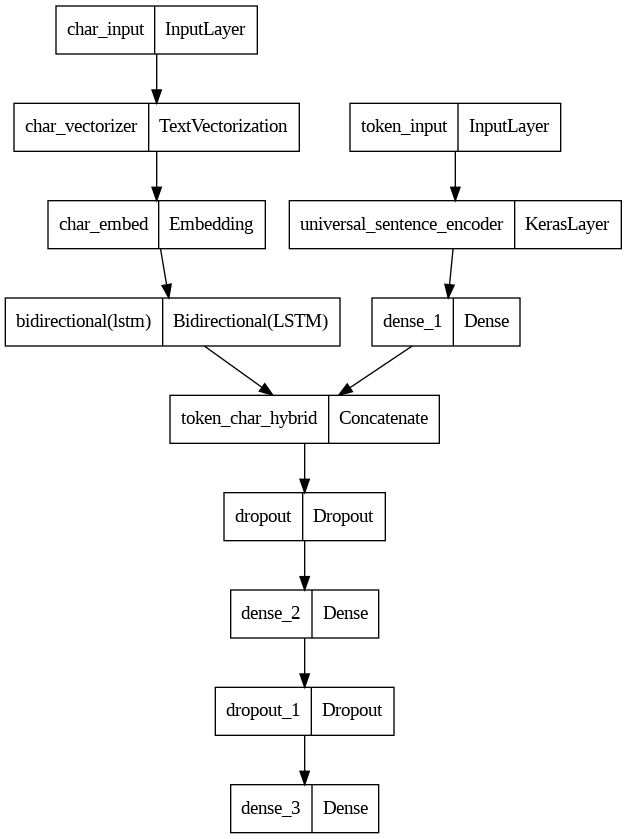

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model_2)

Author of original paper used SGD, But I will use Adam optimizer

In [59]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


For training I will create a tf.data.Dataset with a tuple as the first input

In [60]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Now I will fit the model. I will use only 10% of train and validation batches to speed-up the process.

In [61]:
model_2_history = model_2.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 136s 229ms/step - loss: 0.9656 - accuracy: 0.6156 - val_loss: 0.7770 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 119s 212ms/step - loss: 0.7933 - accuracy: 0.6927 - val_loss: 0.7176 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 120s 213ms/step - loss: 0.7722 - accuracy: 0.7050 - val_loss: 0.6946 - val_accuracy: 0.7354


In [62]:
model_2.evaluate(val_char_token_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6979 - accuracy: 0.7344


[0.6979405283927917, 0.7344432473182678]

In [63]:
model_2_pred_probs = model_2.predict(val_char_token_dataset)
model_2_pred_probs

945/945 [==============================] - 53s 55ms/step


array([[4.5222840e-01, 3.3152747e-01, 3.4389975e-03, 2.0804103e-01,
        4.7641345e-03],
       [3.0174395e-01, 5.4437590e-01, 2.4623489e-03, 1.4981413e-01,
        1.6036737e-03],
       [2.8352121e-01, 1.7088385e-01, 4.8608754e-02, 4.4346890e-01,
        5.3517368e-02],
       ...,
       [3.2855067e-04, 7.0064538e-03, 4.1109644e-02, 1.6409370e-04,
        9.5139128e-01],
       [5.1620142e-03, 5.1782843e-02, 2.2137712e-01, 2.4219255e-03,
        7.1925604e-01],
       [2.0920888e-01, 5.0608337e-01, 2.1593289e-01, 1.8011123e-02,
        5.0763767e-02]], dtype=float32)

In [64]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [65]:
model_2_metrics = calculate_metrics(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_metrics

{'accuracy': 0.7344432675757977,
 'precision': 0.7341111639837358,
 'recall': 0.7344432675757977,
 'f1': 0.7317734946203566}

In [66]:
models_metrics = models_metrics.append(pd.DataFrame({"Model 2 - Char and Token Embed.": model_2_metrics}).transpose())
models_metrics

<ipython-input-66-c5c4b19469a5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(pd.DataFrame({"Model 2 - Char and Token Embed.": model_2_metrics}).transpose())


,accuracy,f1,precision,recall
Baseline-MNB,0.721832,0.698925,0.718647,0.721832
Model 1 - Conv. with Embed.,0.786807,0.784324,0.783825,0.786807
Model 2 - Char and Token Embed.,0.734443,0.731773,0.734111,0.734443


The metrics are worse than comparing to the Model 1. Probalby the reason is the imported Token Embedding layer.

### Model 3: Token embedding + character embedding + positional embedding

#### Creating positional embedding

In [67]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


I will use `line_number` and `total_line` to pass them to the model as positional embedding, which could improve model's perofomance and was done by the author of the paper.

Since it is in numeric format but the value 5 is not more important that 1, I will use one-hot-encoding. For the depth I will explore the `line_number` column

In [68]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

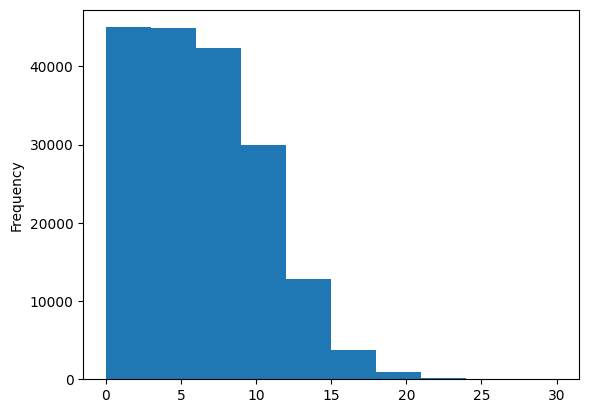

In [69]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [70]:
np.percentile(train_df.line_number, 98)

15.0

Most of lines have a position 15 or less, so I will use this number. *(Values over 15 will be set to 0)*

In [71]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

I will do the same procedure with `total_lines`

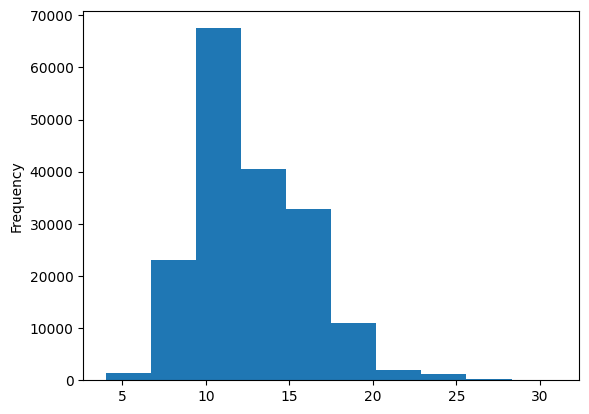

In [72]:
train_df["total_lines"].plot.hist();

In [73]:
np.percentile(train_df.total_lines, 98)

21.0

I will use the value 21 as the depth for one-hot encpding

In [74]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=21)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=21)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=21)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 21]),
 <tf.Tensor: shape=(10, 21), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.,

#### Model configuration

In [75]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(21,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="token_char_embedding")([token_model.output,
                                                                       char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embedding with combined char and token embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
# Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# Combine all
model_3 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [76]:
model_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

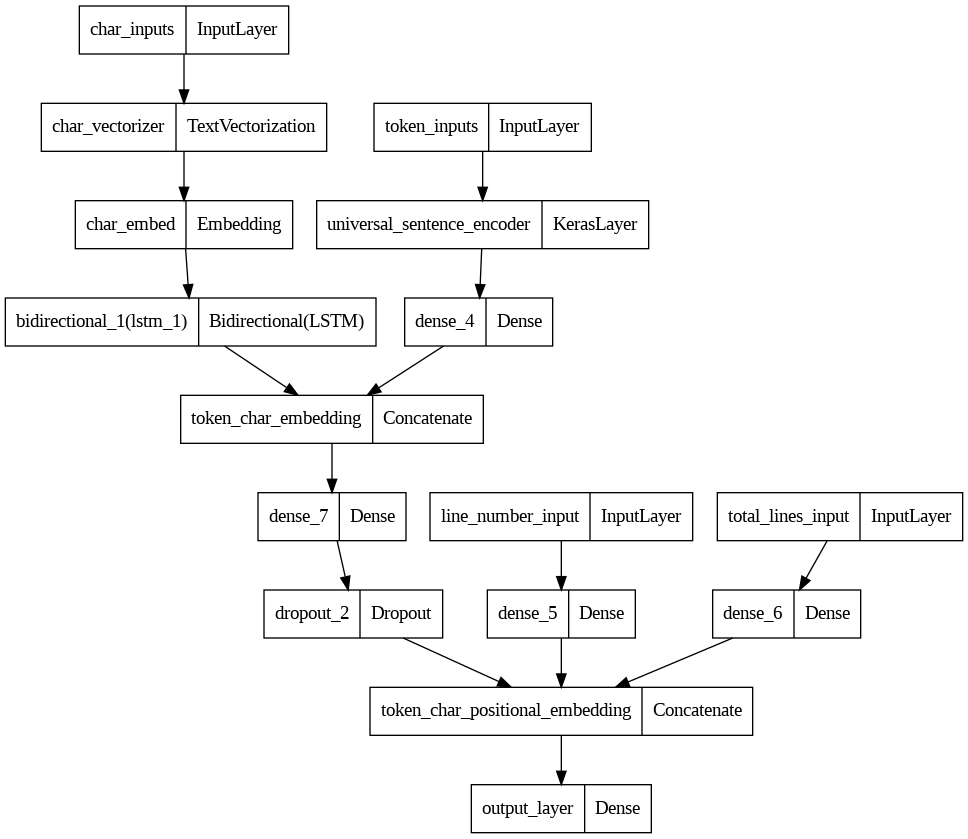

In [77]:
plot_model(model_3)

In [78]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Creating tf.data.Dataset that would pass data as tuples (train line number, train total lines, token sequences tensor, character sequences tensor)

In [79]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 21), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [80]:
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 136s 229ms/step - loss: 1.1001 - accuracy: 0.7194 - val_loss: 0.9910 - val_accuracy: 0.8025
Epoch 2/3
562/562 [==============================] - 131s 234ms/step - loss: 0.9687 - accuracy: 0.8141 - val_loss: 0.9521 - val_accuracy: 0.8311
Epoch 3/3
562/562 [==============================] - 132s 235ms/step - loss: 0.9518 - accuracy: 0.8216 - val_loss: 0.9412 - val_accuracy: 0.8301


In [81]:
model_3.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 55s 58ms/step - loss: 0.9400 - accuracy: 0.8306


[0.939989447593689, 0.8305971026420593]

In [82]:
# Make predictions with token-char-positional hybrid model
model_3_pred_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)
model_3_pred_probs

945/945 [==============================] - 55s 57ms/step


array([[0.459442  , 0.11311958, 0.012161  , 0.39633504, 0.01894246],
       [0.46232137, 0.11840888, 0.0508243 , 0.3568405 , 0.01160493],
       [0.242089  , 0.10819352, 0.10367537, 0.48613337, 0.0599088 ],
       ...,
       [0.03531687, 0.10595866, 0.0408643 , 0.03164399, 0.78621626],
       [0.02862096, 0.32400823, 0.08785235, 0.02694067, 0.53257775],
       [0.26454902, 0.5603065 , 0.06957831, 0.04715554, 0.05841075]],
      dtype=float32)

In [83]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [85]:
model_3_metrics = calculate_metrics(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_metrics

{'accuracy': 0.8305971137296438,
 'precision': 0.8295578429363222,
 'recall': 0.8305971137296438,
 'f1': 0.8298000000186728}

In [86]:
models_metrics = models_metrics.append(pd.DataFrame({"Model 3 - Char, Token and Positional Embed.": model_3_metrics}).transpose())
models_metrics

<ipython-input-86-3ad3b0e79d21>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_metrics = models_metrics.append(pd.DataFrame({"Model 3 - Char, Token and Positional Embed.": model_3_metrics}).transpose())


,accuracy,f1,precision,recall
Baseline-MNB,0.721832,0.698925,0.718647,0.721832
Model 1 - Conv. with Embed.,0.786807,0.784324,0.783825,0.786807
Model 2 - Char and Token Embed.,0.734443,0.731773,0.734111,0.734443
"Model 3 - Char, Token and Positional Embed.",0.830597,0.829800,0.829558,0.830597


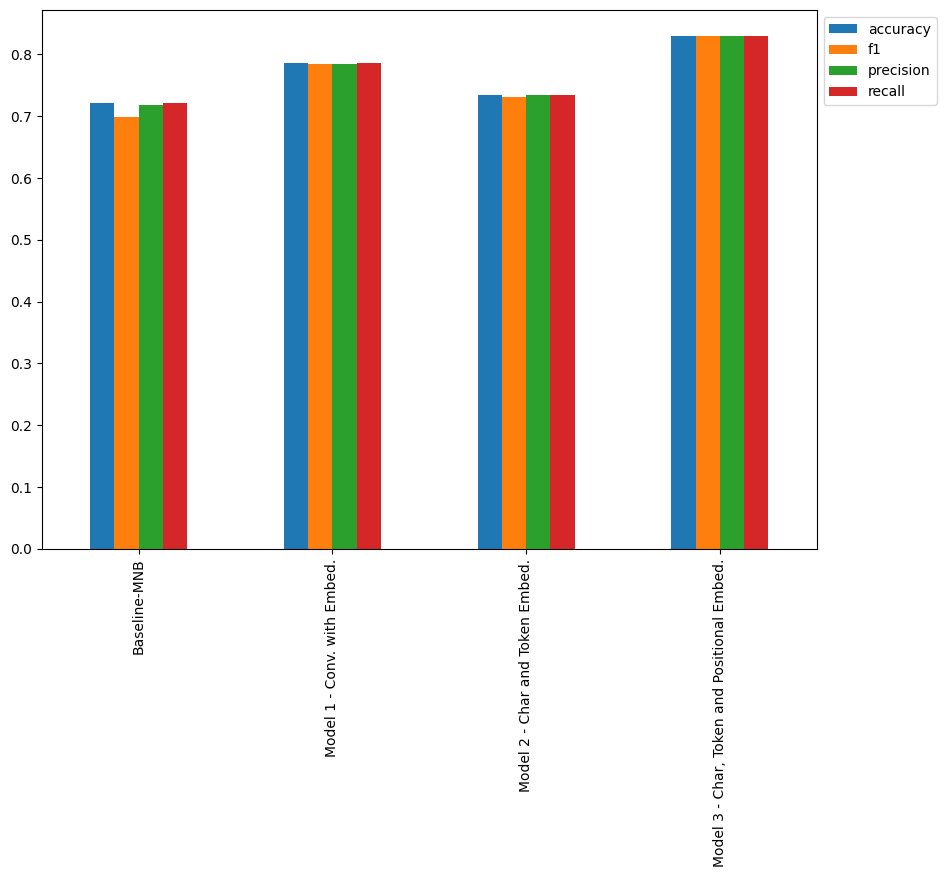

In [87]:
models_metrics.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

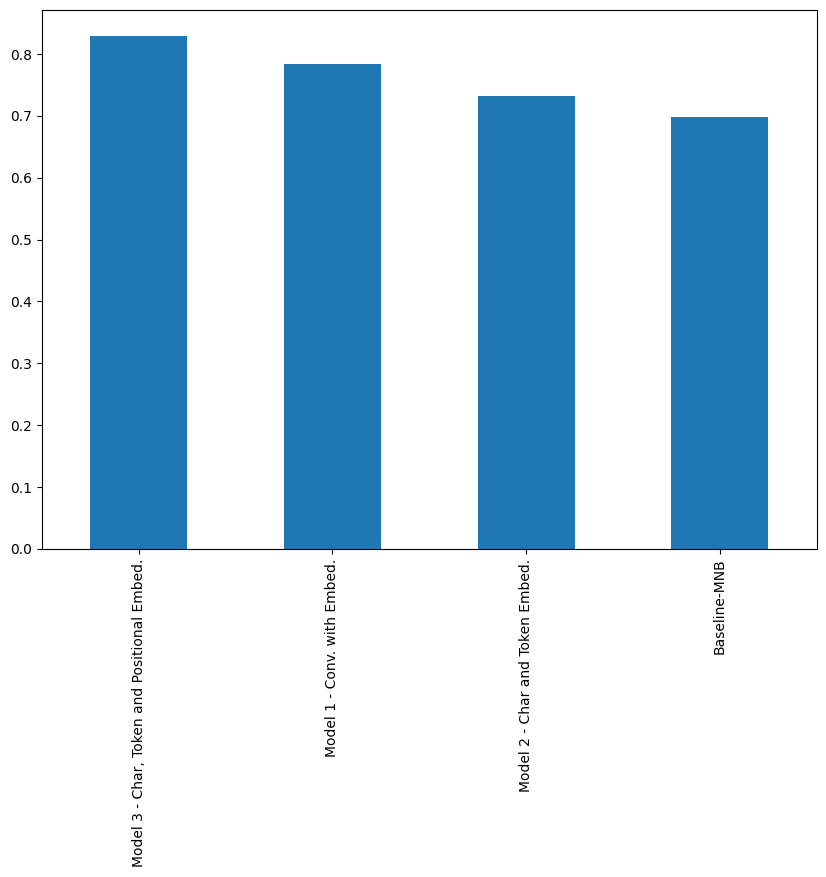

In [88]:
# Sort model results by f1-score
models_metrics.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, last model that has character, token and positional embedding layers performs the best.